# Sprint アンサンブル学習

**Sprintの目的**
- アンサンブル学習について理解する

**どのように学ぶか**

スクラッチでアンサンブル学習の各種手法を実装していきます。

## 1.アンサンブル学習

3種類のアンサンブル学習をスクラッチ実装していきます。そして、それぞれの効果を小さめのデータセットで確認します。


- ブレンディング
- バギング
-スタッキング

### 小さなデータセットの用意
以前も利用した回帰のデータセットを用意します。


[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
#ライブラリのインポート

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使います。


train.csvを学習用（train）8割、検証用（val）2割に分割してください。

In [1]:
#ライブラリのインポート

# data analysis and wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  #データ分割
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# machine learning
import sklearn
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.svm import SVR # SVM 
from sklearn.tree import DecisionTreeRegressor # 決定木
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト 

#model_evaluation & tuning
from sklearn.metrics import mean_squared_error # 平均二乗誤差
from sklearn.metrics import mean_absolute_error # 平均絶対誤差
from sklearn.metrics import r2_score #R^2値

In [2]:
df = pd.read_csv("train.csv")
df = df[['GrLivArea', 'YearBuilt', 'SalePrice']]
df

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000
...,...,...,...
1455,1647,1999,175000
1456,2073,1978,210000
1457,2340,1941,266500
1458,1078,1950,142125


### scikit-learn

単一のモデルはスクラッチ実装ではなく、scikit-learnなどのライブラリの使用を推奨します。


[sklearn.linear_model.LinearRegression — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


[sklearn.svm.SVR — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)


[sklearn.tree.DecisionTreeRegressor — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

<Figure size 864x576 with 0 Axes>

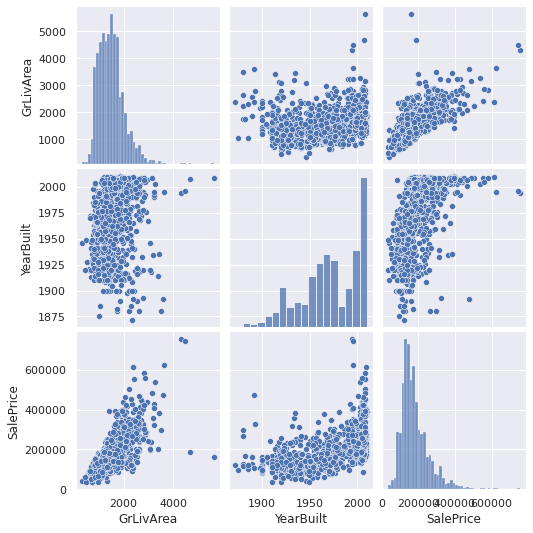

In [3]:
plt.figure(figsize=(12, 8))
sns.pairplot(df, palette='Reds')
sns.set()

In [4]:
# scikit-learnでの処理のため、ndarrayへ変換

X = df.drop('SalePrice', axis=1).values
y = df.loc[:, 'SalePrice'].values
print(X.shape)
print(y.shape)

(1460, 2)
(1460,)


対数変換処理を行う理由に関する参考サイト：https://pisara.hiheki.com/data-analysis/411/data-conversion-normalization/

In [5]:
# yに対して対数変換を行う

y = np.log(y)

In [6]:
# 訓練データ80%、検証データ20%用に分割

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 2)
(292, 2)
(1168,)
(292,)


In [7]:
# 標準化を行う

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [8]:
# 線形回帰

lr = LinearRegression()# インスタンス作成
lr.fit(X_train_std, y_train) # 学習
lr_pred = lr.predict(X_test_std) # 予測
lr_pred.shape

(292,)

In [9]:
# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価

mse_list = []
lr_mse = mean_squared_error(y_test, lr_pred)
mse_list.append(lr_mse)
lr_mse

0.05730354643047342

In [10]:
# SVM

svm = SVR() # インスタンス作成
svm.fit(X_train_std, y_train) # 学習
svm_pred = svm.predict(X_test_std) # 予測

# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価
svm_mse = mean_squared_error(y_test, svm_pred)
mse_list.append(svm_mse)
svm_mse

0.0373344307841314

In [11]:
# 決定木

tree = DecisionTreeRegressor() # インスタンス作成
tree.fit(X_train_std, y_train) # 学習
tree_pred = tree.predict(X_test_std) # 予測

# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価
tree_mse = mean_squared_error(y_test, tree_pred)
mse_list.append(tree_mse)
tree_mse

0.07664029429645695

In [12]:
# 指標値を１つの表にまとめる

compare_df = pd.DataFrame([])
compare_df['MSE'] = mse_list
compare_df.rename(index={0:'線形回帰', 1:'SVM', 2:'決定木'}, inplace=True)
compare_df

,MSE
線形回帰,0.057304
SVM,0.037334
決定木,0.076640


## 2.ブレンディング

## 【問題1】ブレンディングのスクラッチ実装
ブレンディング をスクラッチ実装し、単一モデルより精度があがる例を **最低3つ** 示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを指します。

### ブレンディングとは

ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。


- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることです。


回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。


**《補足》**


分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。


[sklearn.ensemble.VotingClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [13]:
def scratch_blending(*y_preds, y_true, weights=None):
    """
    ブレンディング:各モデルの推定結果を重み付けした上で足し合わせる
    
    Parameters
    ----------
    y_preds : 各モデルの推定結果（可変長引数にするため、*をつける）
    y_true : テストセットの目的変数
    weights : 重み付け
    """
    y_pred_b = np.average(y_preds, axis=0, weights=weights)
    return mean_squared_error(y_true, y_pred_b)

In [14]:
# 試み01 : 線形回帰とSVMのブレンディング(重み付け無し)

scratch_blending(lr_pred, svm_pred, y_true=y_test)

0.04177057821620027

In [15]:
# 別の方法で動作確認
yp_concat = np.concatenate([lr_pred.reshape(len(lr_pred), 1), svm_pred.reshape(len(svm_pred), 1)], 1)

yp_concat_mean = np.mean(yp_concat, axis=1)
mean_squared_error(y_test, yp_concat_mean)

0.04177057821620027

In [16]:
# 試み02 : 線形回帰とSVMのブレンディング(重み付けあり)

weights = np.array([0.3, 0.7])
scratch_blending(lr_pred, svm_pred, y_true=y_test, weights=weights)

0.03866450074950825

In [17]:
# 別の方法で動作確認
yp_concat = np.concatenate([lr_pred.reshape(len(lr_pred), 1), svm_pred.reshape(len(svm_pred), 1)], 1)

weights = np.array([0.3, 0.7])
yp_concat_average = np.average(yp_concat, axis=1, weights=weights)
mean_squared_error(y_test, yp_concat_average)

0.03866450074950825

In [18]:
# 試み03 : 線形回帰とSVMと決定木のブレンディング(重み付けあり)

weights = np.array([0.3, 0.5, 0.2])
scratch_blending(lr_pred, svm_pred, tree_pred, y_true=y_test, weights=weights)

0.03970481922527923

**考察：ブレンディングを行った結果、svmには少し劣るが、線形回帰と決定木単独の精度よりは改善が見られた。**

## 3.バギング

## 【問題2】バギングのスクラッチ実装
**バギング** をスクラッチ実装し、単一モデルより精度があがる例を **最低1つ** 示してください。

### バギングとは

バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ **ブートストラップサンプル** ）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。


[sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)


scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。


推定結果の平均をとる部分はブースティングと同様の実装になります。

In [19]:
def scratch_bagging(n, X_train, y_train, X_test):
    """
    バギング:学習データから重複を許した上でランダムに抜き出し、複数の推定結果の平均をとる
    
    Parameters
    ----------
    n : N種類のサブセット（ ブートストラップサンプル ）
    X_train : 訓練セットの特徴量
    y_train : 訓練セットの目的変数
    X_test : テストセットの特徴量
    """
    # 予測結果を格納する空のndarrayを作っておく
    y_pred_b = np.empty((n, X_test.shape[0]))
    for i in range(n):
        # データ分割（shuffleパラメータはTrue（デフォルト）にしてランダムにデータを分割させる）
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, shuffle=True)
        tree_b = DecisionTreeRegressor() # インスタンス作成
        tree_b.fit(X_train_b, y_train_b) # 学習
        y_pred_b[i] = tree_b.predict(X_test) # 予測
#         print('y_pred_b', y_pred_b)
#         print('----------------')
    
    return np.average(y_pred_b, axis=0)

In [20]:
# nを1回で動作確認（決定木単独のmseは0.07460208472403367）
y_pred_bagging = scratch_bagging(1, X_train_std, y_train, X_test_std)
# y_pred_bagging.shape

# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価
scratch_bagging_mse = mean_squared_error(y_test, y_pred_bagging)
scratch_bagging_mse

0.07522512691386764

In [21]:
# nを3回で回してみる
y_pred_bagging03 = scratch_bagging(3, X_train_std, y_train, X_test_std)
# y_pred_bagging.shape

# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価
scratch_bagging_mse = mean_squared_error(y_test, y_pred_bagging03)
scratch_bagging_mse

0.05683779112626788

In [22]:
# nを10回で回してみる
y_pred_bagging10 = scratch_bagging(3, X_train_std, y_train, X_test_std)
# y_pred_bagging.shape

# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価
scratch_bagging_mse = mean_squared_error(y_test, y_pred_bagging10)
scratch_bagging_mse

0.055581656089881484

**考察：バギングを行った結果、決定木単独より精度の改善が見られた。**

## 4.スタッキング

## 【問題3】スタッキングのスクラッチ実装
スタッキング をスクラッチ実装し、単一モデルより精度があがる例を **最低1つ** 示してください。

In [23]:
class Stacking_Scratch():
    """
    スタッキングのクラス(テージ0とステージ1のみ)
    
    Parameters
    ----------
    initial_models : ステージ0でのモデルインスタンスのリスト
    final_model : ステージ1でのモデルインスタンス
    n_splits : KFoldクラスの分割数
    
    Attributes
    ----------
    blend_data : trainデータのステージ1での予測値 ndarray(n_samples, n_models)       
    new_feature : testデータのステージ1での予測値 ndarray(n_samples, n_models)
    """
    def __init__(self, initial_models, final_model, n_splits=3):
        # ハイパーパラメータを属性として記録
        self.initial_models = initial_models
        self.final_model = final_model
        self.blend_data = None
        self.new_feature = None
        self.n_splits = n_splits
        self.fitted_models = {}
    
    def fit(self, X, y):
        """
        スタッキングの学習

        Parameters
        ----------
        X : 学習用データの特徴量 次の形のndarray, shape (n_samples, n_features)    
        y : 学習用データの正解値 次の形のndarray, shape (n_samples, )
        """       
        # KFoldをインスタンス化
        kf = KFold(n_splits=3, shuffle=True, random_state=42)

        # ブレンドデータを保存する空の箱を作っておく(shape(n_samples, n_models))
        self.blend_data = np.zeros([X.shape[0], len(initial_models)])

        #学習
        #initial_modelsの数だけfor文を回す
        for i, model in enumerate(self.initial_models):

            # fitしたモデルをmodel_listに追加するための空のlistを作っておく
            model_list = []

            # KFoldクラスでデータをクロスバリデーションで分割
            for train_index, test_index in kf.split(X):

                # train_indexのみを使ってfit
                model.fit(X[train_index], y[train_index])

                # fitしたモデルをmodel_listに追加
                model_list.append(model)
#                 print('model_list', model_list)

                # test_indexを予測
                pred = model.predict(X[test_index])
#                 print('pred', pred)

                # 予測値をブレンドデータとして格納
                self.blend_data[test_index, i] = pred
#                 print('self.blend_data', self.blend_data)

            # for文で回した学習済みモデルを全部辞書に格納
            self.fitted_models['model_{}'.format(i)] = model_list
#             print('self.fitted_models', self.fitted_models)

        # ブレンドデータを新しい特徴量として、final_modelがfitする
        self.final_model.fit(self.blend_data, y)
    
    def predict(self, X):
        """
        スタッキングの推定

        Parameters
        ----------
        X : 学習用データの特徴量 次の形のndarray, shape (n_samples, n_features)    
        """
        # 予測値を一時格納する空のリストを作成
        preds = [] 
        # testデータの予測値を保存する箱を作っておく(shape(n_samples, n_models))
        self.new_feature = np.zeros([X.shape[0], len(self.initial_models)])

        # ステージ０の推定用に辞書に格納した学習済みモデルを取り出してfor文で回す
        for i, models in enumerate(self.fitted_models.values()):
            for j in range(self.n_splits):
                pred = models[j].predict(X)
                self.new_feature[:, i] += pred # 箱の中の要素毎に推定値を足していく
            self.new_feature[:, i] /= self.n_splits # モデルごとn_splits回足した推定値の平均を取る

        # 最後メタモデルで予測したものを返す        
        return self.final_model.predict(self.new_feature) 

In [24]:
# initial_modelsは線形回帰と決定木の2つにし、final_modelをSVMにする

# 各モデルのインスタンス化
lr_s = LinearRegression() #線形回帰
tree_s = DecisionTreeRegressor() # 決定木
svm_s = SVR()

# インスタンス化したモデルを辞書に格納し、metaモデルを最後に置く
models_dict = {'lr_s':lr_s, 'tree_s':tree_s, 'svm_s':svm_s}
# ベースモデルとメタモデルに分ける
initial_models = list(models_dict.values())[:-1]
final_model = list(models_dict.values())[-1]

In [25]:
# Stacking_Scratchを動インスタンス化

Stacking_Scratch = Stacking_Scratch(initial_models=initial_models, final_model=final_model, n_splits=3)

In [26]:
# 学習

Stacking_Scratch.fit(X_train_std, y_train)

In [27]:
# 予測

Stacking_Scratch_pred = Stacking_Scratch.predict(X_test_std) 

In [28]:
# 平均二乗誤差（Mean Squared Error, MSE）を用いて評価

Stacking_Scratch_mse = mean_squared_error(y_test, Stacking_Scratch_pred)
Stacking_Scratch_mse

0.03958264372436171

In [29]:
# 単独モデルの線形回帰と決定木の平均二乗誤差を再掲

lr_mse = mean_squared_error(y_test, lr_pred)
print('線形回帰単体の平均二乗誤差', lr_mse)

tree_mse = mean_squared_error(y_test, tree_pred)
print('決定木単体の平均二乗誤差', tree_mse)

線形回帰単体の平均二乗誤差 0.05730354643047342
決定木単体の平均二乗誤差 0.07664029429645695


**考察：スタッキングを行った結果、線形回帰と決定木単独より精度の改善が見られた。**